## Geospatial Analysis II:  buffers, cost surfaces, least cost path
Resources:

* [
GRASS GIS overview and manual](http://grass.osgeo.org/grass74/manuals/index.html)
*  [Recommendations](data_acquisition.html#commands)
and [tutorial](./grass_intro.html)
how to use GUI from the first assignment



Text files with recode rules, color rules and site locations:

* [noise_cats.txt](data/noise_cats.txt)
* [friction_rules.txt](data/friction_rules.txt)
* [friction_color.txt](data/friction_color.txt)
* [fire_pt.json](data/fire_pt.json)
* [lostperson.txt](data/lostperson.txt)


### Start GRASS GIS
In startup pannel set GIS Data Directory to path to datasets,
for example on MS Windows, `C:\Users\myname\grassdata`.
For Project location select nc_spm_08_grass7 (North Carolina, State Plane, meters) and
for Accessible mapset create a new mapset (called e.g. HW_buffers_cost) and
click Start GRASS.

In [1]:
# This is a quick introduction into Jupyter Notebook.
# Python code can be executed like this:
a = 6
b = 7
c = a * b
print "Answer is", c
# Python code can be mixed with command line code (Bash).
# It is enough just to prefix the command line with an exclamation mark:
!echo "Answer is $c"
# Use Shift+Enter to execute this cell. The result is below.

Answer is 42
Answer is 42


In [2]:
import os
import sys
import subprocess
from IPython.display import Image

# create GRASS GIS runtime environment
gisbase = subprocess.check_output(["grass", "--config", "path"]).strip()
os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# do GRASS GIS imports
import grass.script as gs
import grass.script.setup as gsetup

# set GRASS GIS session data
rcfile = gsetup.init(gisbase, "/home/jovyan/grassdata", "nc_spm_08_grass7", "user1")

In [3]:
# default font displays
os.environ['GRASS_FONT'] = 'sans'
# overwrite existing maps
os.environ['GRASS_OVERWRITE'] = '1'
gs.set_raise_on_error(True)
gs.set_capture_stderr(True)

True

In [4]:
# set display modules to render into a file (named map.png by default)
os.environ['GRASS_RENDER_IMMEDIATE'] = 'cairo'
os.environ['GRASS_RENDER_FILE_READ'] = 'TRUE'
os.environ['GRASS_LEGEND_FILE'] = 'legend.txt'

Remove MASK in case it was left over
from previous assignment (use command `r.mask -r`).

Change working directory:
_Settings_ > _GRASS working environment_ > _Change working directory_ > select/create any directory
or type `cd` (stands for change directory) into the GUI
_Console_ and hit Enter:

In [5]:
# a proper directory is already set, download files
import urllib
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/noise_cats.txt", "noise_cats.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/friction_rules.txt", "friction_rules.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/friction_color.txt", "friction_color.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/fire_pt.json", "fire_pt.json")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/lostperson.txt", "lostperson.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/noise_cats.txt", "noise_cats.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/fire_pt.json", "fire_pt.json")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/friction_rules.txt", "friction_rules.txt")
urllib.urlretrieve("http://ncsu-geoforall-lab.github.io/geospatial-modeling-course/grass/data/lostperson.txt", "lostperson.txt")

('lostperson.txt', <httplib.HTTPMessage instance at 0x7fcca9a02950>)

Download all text files with recode rules, color rules and site locations (see above)
to the selected directory. Now you can use the commands from the assignment requiring the text file
without the need to specify the full path to the file.




### Buffers
#### Find developed areas close to lakes
Set region, create buffers:

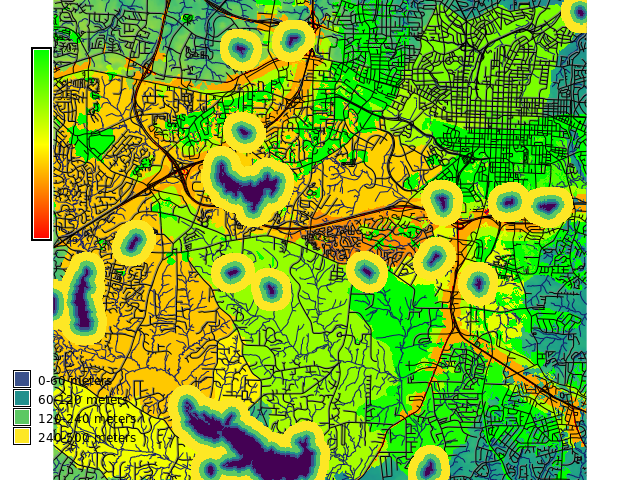

In [6]:
gs.parse_command('g.region', region="swwake_30m", flags='pg')
gs.run_command('r.buffer', input="lakes", output="lakes_buff", distances="60,120,240,500")
gs.run_command('d.rast', map="lakes_buff")
Image(filename="map.png")

List categories in land use map to identify category numbers for developed areas.
Then run _r.mapcalc_ to extract the developed areas within the buffers
and use _r.support_ to assign the labels from the original buffer raster 
to the new developed buffer raster map (needed for legend):

In [7]:
print gs.read_command('r.category', map="landuse96_28m")
gs.mapcalc("developed_lake = if(landuse96_28m==1 || landuse96_28m==2, lakes_buff, null())")
gs.run_command('r.support', map="developed_lake", raster="lakes_buff")
print gs.read_command('r.category', map="developed_lake")

0	not classified
1	High Intensity Developed
2	Low Intensity Developed
3	Cultivated
4	Managed Herbaceous Cover
6	Riverine/Estuarine Herbaceous
7	Evergreen Shrubland
8	Deciduous Shrubland
9	Mixed Shrubland
10	Mixed Hardwoods
11	Bottomland Hardwoods/Hardwood Swamps
15	Southern Yellow Pine
18	Mixed Hardwoods/Conifers
20	Water Bodies
21	Unconsolidated Sediment

1	distances calculated from these locations
2	0-60 meters
3	60-120 meters
4	120-240 meters
5	240-500 meters



Display results:
In GUI: switch off previous map, use Add raster, Add vector icons.

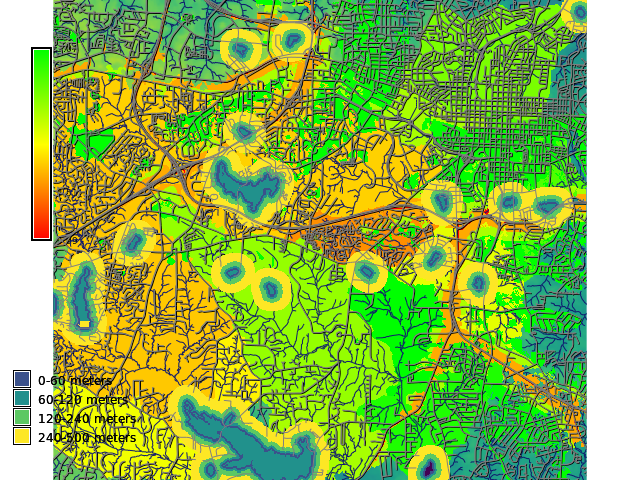

In [8]:
gs.run_command('d.rast', map="developed_lake")
gs.run_command('d.vect', map="streets_wake", color="grey")
gs.run_command('d.rast', map="lakes")
gs.run_command('d.legend', raster="developed_lake", use="2,3,4,5", at="5,25,2,5", flags='c')
Image(filename="map.png")

Find the total area within buffers and the developed area in ha:

In [9]:
print gs.read_command('r.report', map="lakes_buff", units="h", flags='n')
print gs.read_command('r.report', map="developed_lake", units="h", flags='n')

+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Mon Jan  7 21:43:21 2019|
|-----------------------------------------------------------------------------|
|          north: 228500    east: 645000                                      |
|REGION    south: 215000    west: 630000                                      |
|          res:       30    res:      30                                      |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: Distance Zones (lakes_buff in user1)                                    |
|-----------------------------------------------------------------------------|
|                      Category Informat

#### Find developed areas impacted by noise from highways
Set region and create buffers along major roads.
Intersect developed areas from landuse map with road buffers.
Transfer the category labels and compute the affected area.
Run _r.category_ from GUI and browse to the txt file,
or run _r.category_ command (assuming [noise_cats.txt](data/noise_cats.txt)
is in your working directory).

In [10]:
gs.parse_command('g.region', raster="landuse96_28m", flags='pg')
gs.run_command('r.buffer', input="roadsmajor", output="roads_buffers", distances="250,500,2500")
gs.mapcalc("noise = if(landuse96_28m==1 || landuse96_28m==2, roads_buffers, null())")
gs.run_command('r.colors', map="noise", color="ryg")
print gs.read_command('r.category', map="noise", rules="noise_cats.txt", separator=":")
print gs.read_command('r.report', map="noise", units="p,h", flags='n')


+-----------------------------------------------------------------------------+
|                         RASTER MAP CATEGORY REPORT                          |
|LOCATION: nc_spm_08_grass7                           Mon Jan  7 21:43:22 2019|
|-----------------------------------------------------------------------------|
|          north: 228527.25    east: 644971                                   |
|REGION    south: 215018.25    west: 629980                                   |
|          res:        28.5    res:    28.5                                   |
|-----------------------------------------------------------------------------|
|MASK: none                                                                   |
|-----------------------------------------------------------------------------|
|MAP: (untitled) (noise in user1)                                             |
|-----------------------------------------------------------------------------|
|                   Category Informatio

Display the results. In GUI switch off previous maps.

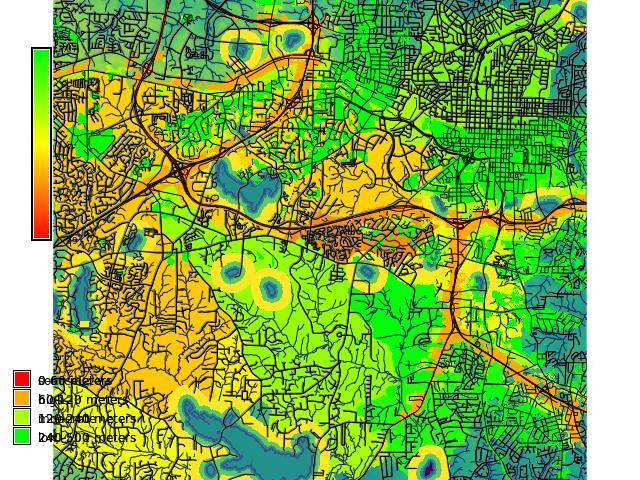

In [11]:
gs.run_command('d.rast', map="noise")
gs.run_command('d.vect', map="streets_wake")
gs.run_command('d.legend', raster="noise", at="5,25,2,5", flags='c')
Image(filename="map.png")

#### Find schools affected by high levels of noise
Convert schools to raster using CORECAPACI attribute (school capacity).
Use map algebra to overlay with noise impact buffers and
compute the number of students exposed to noise (see result of _r.univar_).

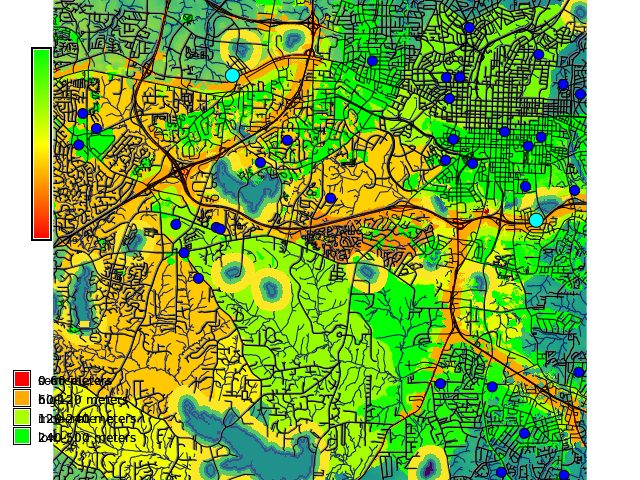

In [12]:
gs.run_command('v.to.rast', input="schools_wake", output="schoolscap_10m", use="attr", attrcolumn="CORECAPACI", type="point")
gs.mapcalc("schools_noise = if(int(schoolscap_10m) && roads_buffers == 2, int(schoolscap_10m), null())")
gs.parse_command('r.univar', map="schools_noise", flags='g')
gs.run_command('r.to.vect', input="schools_noise", output="schools_noise", type="point")
gs.run_command('d.vect', map="schools_wake", icon="basic/circle", size="10", fill_color="blue")
gs.run_command('d.vect', map="schools_noise", size="14", fill_color="cyan", icon="basic/circle", color="black")
Image(filename="map.png")

### Cost surfaces

#### Compute cumulative cost surface to a given accident site based on speed limits

Use 5mi/hr speed limit for off-road areas (nulls).
For legend set the discrete speed limit values in GUI legend dialog:
tab _Required_ > streets_speed, _Subset_ > _List of discrete category numbers_

INTEGER|cat
INTEGER|STSEG
INTEGER|STID
CHARACTER|STNAME
CHARACTER|DIR_PRE
CHARACTER|DIR_SUF
CHARACTER|STYPE
INTEGER|CLASS
INTEGER|F_ELEV
INTEGER|T_ELEV
CHARACTER|MAP
CHARACTER|PRIV
INTEGER|FRLEFT
INTEGER|TOLEFT
INTEGER|FRRIGHT
INTEGER|TORIGHT
INTEGER|FRLEFT_A
INTEGER|TOLEFT_A
INTEGER|FRRIGHT_A
INTEGER|TORIGHT_A
INTEGER|STATEROAD
CHARACTER|CARTONAME
CHARACTER|CORP
INTEGER|SPEED
CHARACTER|ONE_WAY
CHARACTER|CLASSNAME
CHARACTER|L_ZIPNAME
CHARACTER|R_ZIPNAME
DOUBLE PRECISION|FT_COST
DOUBLE PRECISION|TF_COST
CHARACTER|LABELNAME
INTEGER|F_NODE
INTEGER|T_NODE
CHARACTER|CARTOLEVEL
DOUBLE PRECISION|SHAPE_LEN



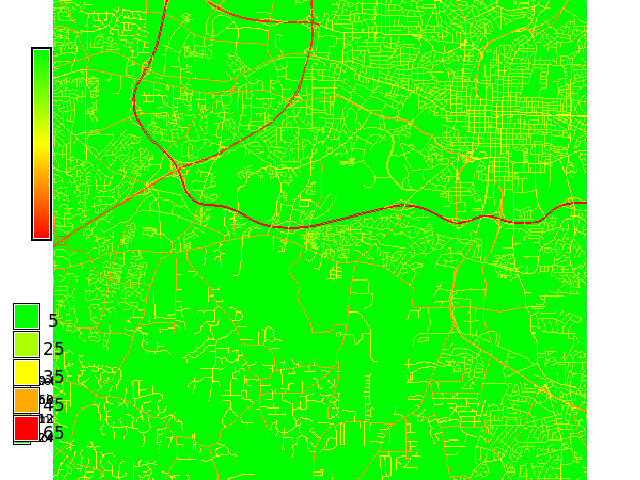

In [13]:
gs.parse_command('g.region', region="swwake_30m", flags='pg')
print gs.read_command('v.info', map="streets_wake", flags='c')
gs.run_command('v.to.rast', input="streets_wake", output="streets_speedtmp", use="attr", attrcolumn="SPEED", type="line")
gs.mapcalc("streets_speed = if(isnull(streets_speedtmp),5,streets_speedtmp)")
gs.parse_command('r.info', map="streets_speed", flags='g')
gs.run_command('r.colors', map="streets_speed", color="gyr")
gs.run_command('d.rast', map="streets_speed")
gs.run_command('d.legend', raster="streets_speed", at="5,40,2,5", use="5,25,35,45,65")
Image(filename="map.png")

Import the accident point location from GeoJSON file [fire_pt.json](data/fire_pt.json)
Run _v.in.ogr_ from GUI, use file browser to provide full path to the file,
or run the command assuming the file is in your working directory.

In [14]:
gs.run_command('v.in.ogr', input="fire_pt.json", output="fire_pt")

0

Assign travel time to cross a 30m grid cell in hours.
Note that cost in GRASS GIS is defined as travel time per _cell_.

Compute cumulative cost surface to the given point.
Where does the 0.018641 constant come from?
You can modify the expression to get time in minutes.

In [15]:
gs.mapcalc("streets_travtime = 0.018641/streets_speed")
gs.run_command('r.cost', input="streets_travtime", output="streets_cost", start_points="fire_pt", flags='k')

0

Compute isochrones and display the cumulative cost surface map.

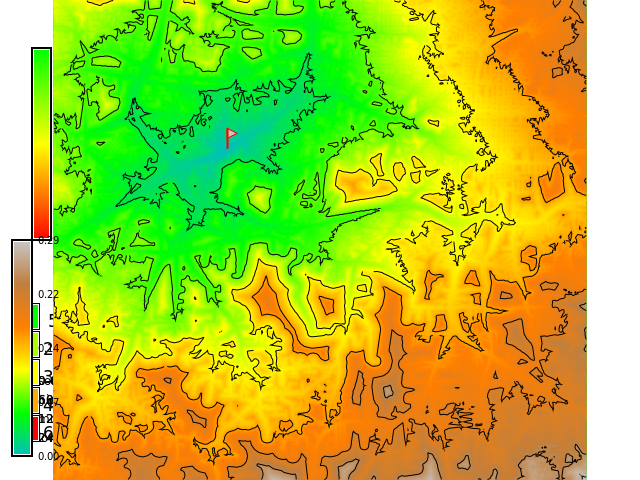

In [16]:
gs.run_command('r.contour', input="streets_cost", output="streets_cost_04", step="0.04")
gs.run_command('r.colors', map="streets_cost", color="elevation")
gs.run_command('d.rast', map="streets_cost")
gs.run_command('d.vect', map="fire_pt", color="red", icon="basic/marker", size="20")
gs.run_command('d.vect', map="streets_cost_04")
gs.run_command('d.legend', raster="streets_cost", at="5,50,2,5")
Image(filename="map.png")

#### Find cost (travel time) from selected firestations

First make your own copy of the firestations map and list attributes.
Then query the cumulative cost surface at the firestations location.
The travel time in hours will be stored in the attribute column CVLAG.

In [17]:
gs.run_command('g.copy', vector="firestations,myfirestations")
print gs.read_command('v.info', map="myfirestations", flags='c')
gs.run_command('v.what.rast', map="myfirestations", raster="streets_cost", column="CVLAG")

INTEGER|cat
INTEGER|ID
CHARACTER|LABEL
CHARACTER|LOCATION
CHARACTER|CITY
CHARACTER|MUN_COUNT
INTEGER|PUMPERS
INTEGER|PUMPER_TAN
INTEGER|TANKER
DOUBLE PRECISION|MINI_PUMPE
INTEGER|RESCUE_SER
INTEGER|AERIAL
INTEGER|BRUSH
INTEGER|OTHERS
INTEGER|WATER_RESC
INTEGER|MUNCOID
CHARACTER|BLDGCODE
CHARACTER|AGENCY
CHARACTER|STATIONID
DOUBLE PRECISION|RECNO
CHARACTER|CV_SID2
DOUBLE PRECISION|CVLAG



0

Add myfirestations to Layer Manager and right click on Show attribute data.
Click on CVLAG to order them and find the lowest cost (shortest time) > 0
(firestations with 0 cost are outside the region).
You should see a [table like this](img/firestations_table.png).
Export firestations with traveltime less than 0.1 hr:

In [18]:
gs.run_command('v.out.ascii', input="myfirestations", separator="space", precision="3", columns="ID,LOCATION,CVLAG", where="CVLAG<0.1 AND CVLAG>0")

0

You should get something like the following:
```
635775.565 228121.693 19 19 4021 District Dr 0.076
635940.262 225912.796 20 0 5001 Western Blvd 0.037
637386.831 222569.152 21 0 1721 Trailwood Dr 0.071
633178.155 221353.037 52 27 6000 Holly Springs Rd 0.060
```


To get the computed time, you can also query the cumulative cost raster directly
using coordinates (in this example it's Western Blvd firestation),
or using GUI query tool by selecting the cost layer and clicking on the map:

In [19]:
gs.run_command('r.what', map="streets_cost", coordinates="635940.262,225912.796", separator="space")

0

Find the least cost path for the two closest stations:

In [20]:
gs.run_command('r.drain', input="streets_cost", output="route_20Westernb", start_coordinates="635940.3,225912.8", flags='n')
gs.run_command('r.drain', input="streets_cost", output="route_52Hollyb", start_coordinates="633178.2,221353.0", flags='n')
gs.run_command('r.colors', map="route_20Westernb", color="grey")
gs.run_command('r.colors', map="route_52Hollyb", color="grey")

0

Display the results in GUI.
You already may have some of these maps in GUI layer tree,
so just switch them on and off and re-order as needed:

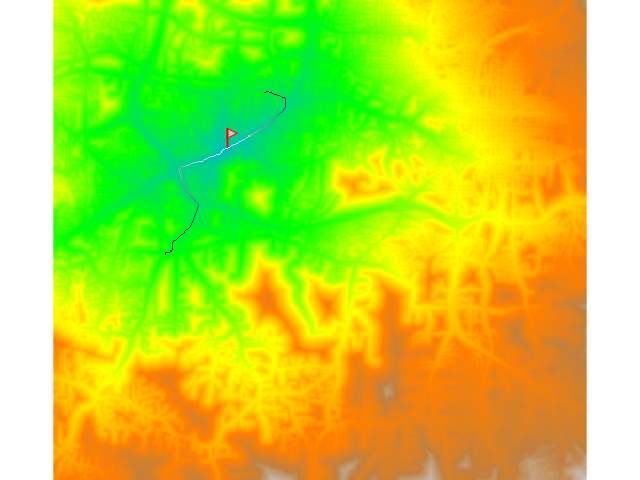

In [21]:
gs.run_command('d.erase')
gs.run_command('d.rast', map="streets_cost")
gs.run_command('d.vect', map="fire_pt", color="red", icon="basic/marker", size="20")
gs.run_command('d.rast', map="route_20Westernb")
gs.run_command('d.rast', map="route_52Hollyb")
Image(filename="map.png")

Print the length of the path in cells (multiply by 30m to get approx. m).
You should have the time in hr already from the cost map.
At what average speed [km/hr] needs the truck travel to get there in estimated time?
Is the time, speed and distance realistic?

In [22]:
gs.run_command('r.describe', map="route_20Westernb")
gs.run_command('r.describe', map="route_52Hollyb")

0

If you would like to display streets_cost surface in 3D as shown in the lecture,
you need to multiply the surface by 1000 using _r.mapcalc_ because the numbers
in hours are very low.
Then switch off all layers except for the streets_cost_1000
and change display to 3D.

#### Compute accessibility map for help in search for lost person
Create friction map based on land cover.
Reminder: Time to time, you should remove or at least uncheck previously
used map layers in the _Layer Manager_, so the layers are not rendered
when you don't need them anymore.
First display land cover classes:

In [23]:
gs.parse_command('g.region', region="swwake_30m", flags='pg')
print gs.read_command('r.category', map="landclass96")

1	developed
2	agriculture
3	herbaceous
4	shrubland
5	forest
6	water
7	sediment



Recode the landuse map to friction map using the rules in 
[friction_rules.txt](data/friction_rules.txt).

In [24]:
gs.run_command('r.recode', input="landclass96", out="friction", rules="friction_rules.txt")

0

Add the streets to friction map - they are missed by the landuse map.

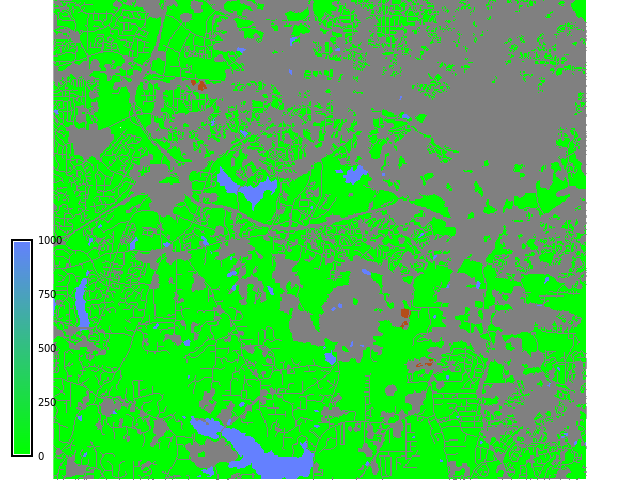

In [25]:
gs.mapcalc("friction2 = if(streets_speed > 6, 0.1, friction)")
gs.run_command('r.colors', map="friction2", rules="friction_color.txt")
gs.run_command('d.erase')
gs.run_command('d.rast', map="friction2")
gs.run_command('d.legend', raster="friction2", at="5,50,2,5")
Image(filename="map.png")

Compute the cost map and generate isochrones:

In [26]:
gs.run_command('r.walk', elevation="elev_ned_30m", friction="friction2", output="walkcost", start_coordinates="635576,216485", lambda_="0.5", max_cost="10000", flags='k')
gs.run_command('r.contour', input="walkcost", output="walkcost", step="1000")

0

To display the input, import coordinates of the point where the lost person was last seen
given in the file [lostperson.txt](data/lostperson.txt).

In [27]:
gs.run_command('v.in.ascii', input="lostperson.txt", output="lostperson", separator="comma")

0

Uncheck the friction map and display the results:

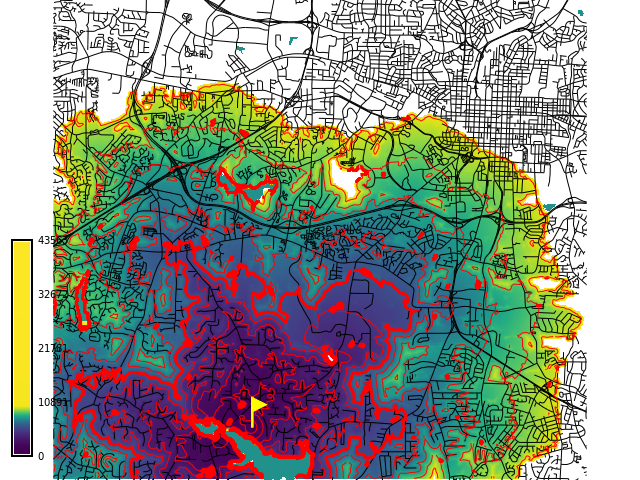

In [28]:
gs.run_command('d.erase')
gs.run_command('r.colors', map="walkcost", color="viridis", flags='e')
gs.run_command('d.rast', map="lakes")
gs.run_command('d.rast', map="walkcost")
gs.run_command('d.vect', map="streets_wake")
gs.run_command('d.vect', map="walkcost", color="red")
gs.run_command('d.vect', map="walkcost", color="red", where="level=6000", width="3")
gs.run_command('d.vect', map="lostperson", color="yellow", fill_color="yellow", icon="basic/marker", size="30")
gs.run_command('d.legend', raster="walkcost", at="5,50,2,5")
Image(filename="map.png")

#### Cost surfaces to line features
Compute the shortest distance to a major road.
Set region, convert vector road map to raster:

In [29]:
gs.parse_command('g.region', region="swwake_30m", flags='pg')
gs.run_command('v.to.rast', input="roadsmajor", output="roadsmajor", use="val", type="line")

0

Compute the distance map and cost surface to highways:

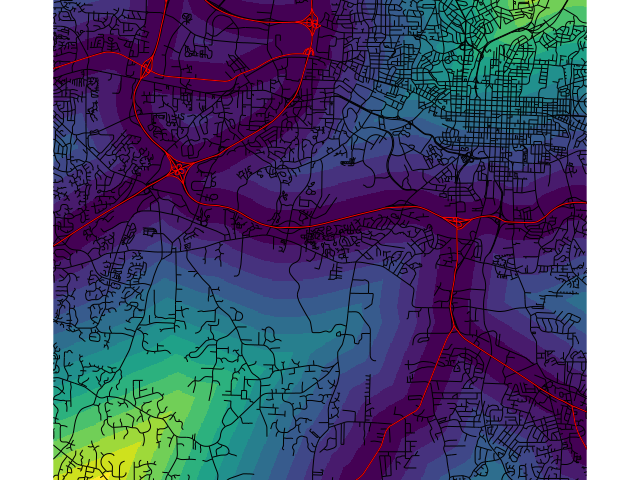

In [30]:
gs.mapcalc("area_one = 1")
gs.run_command('r.cost', input="area_one", output="dist_toroad", start_rast="roadsmajor")
gs.mapcalc("dist_meters = dist_toroad * (ewres() + nsres())/2.")
gs.mapcalc("dist_class = int(dist_meters/500)")
gs.run_command('d.erase')
gs.run_command('d.rast', map="dist_class")
gs.run_command('d.vect', map="roadsmajor")
Image(filename="map.png")
gs.run_command('d.vect', map="streets_wake", color="black")
gs.run_command('d.vect', map="roadsmajor", color="red")
Image(filename="map.png")

In [31]:
# end the GRASS session
os.remove(rcfile)